In [1]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [3]:
def scaled_dot_product_attention(q, k, v):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)

    Returns:
    output, attention_weights
    """

    qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(qk, axis=-1)  # (..., seq_len_q, seq_len_k)
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
    
    return output, attention_weights

In [4]:
class AttentionModel(tf.keras.layers.Layer):
    def __init__(self, d_model, analytical_solution=False):
        super(AttentionModel, self).__init__()
        self.d_model = d_model

        if analytical_solution:
            key_and_query_initializer = tf.keras.initializers.Identity(1000)
            value_initializer = tf.keras.initializers.Identity()
            self.wq = tf.keras.layers.Dense(d_model, use_bias=False, name='Q', kernel_initializer=key_and_query_initializer)
            self.wk = tf.keras.layers.Dense(d_model, use_bias=False, name='K', kernel_initializer=key_and_query_initializer)
            self.wv = tf.keras.layers.Dense(d_model, use_bias=False, name='V', kernel_initializer=value_initializer)
            
        else:
            self.wq = tf.keras.layers.Dense(d_model, use_bias=False, name='Q')
            self.wk = tf.keras.layers.Dense(d_model, use_bias=False, name='K')
            self.wv = tf.keras.layers.Dense(d_model, use_bias=False, name='V')

    def call(self, x):
        batch_size = tf.shape(x)[0]

        q = self.wq(x)  # (batch_size, seq_len, d_model)
        k = self.wk(x)  # (batch_size, seq_len, d_model)
        v = self.wv(x)  # (batch_size, seq_len, d_model)

        
        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v)

        y = tf.math.reduce_sum(scaled_attention[:, 0], axis=-1)

        return y
    
    
model = AttentionModel(2)
analytical = AttentionModel(2, True)

In [5]:
temp_input = tf.random.uniform((2, 1), dtype=tf.float32, minval=0, maxval=1)
analytical(temp_input)
analytical.trainable_variables

[<tf.Variable 'attention_model_1/Q/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[1000.,    0.]], dtype=float32)>,
 <tf.Variable 'attention_model_1/K/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[1000.,    0.]], dtype=float32)>,
 <tf.Variable 'attention_model_1/V/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[1., 0.]], dtype=float32)>]

In [6]:
def gen_dataset(size, batch_size=32):
    n = 2
    x = np.random.random((size, n, 1))
    y = x.max(axis=1)

    return tf.data.Dataset.from_tensor_slices((x, y)).batch(batch_size)



train_ds = gen_dataset(500)
test_ds = gen_dataset(5000)

In [7]:
for one, _ in test_ds:
    print(one[0])
    break

tf.Tensor(
[[0.5611439 ]
 [0.38295653]], shape=(2, 1), dtype=float64)


In [8]:
for one, _ in test_ds:
    print(model(one)[0])
    break


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(0.15397447, shape=(), dtype=float32)


In [9]:
metric = tf.keras.metrics.MeanSquaredError(
    name='mean_squared_error', dtype=None
)

test_metric = tf.keras.metrics.MeanSquaredError(
    name='test_mean_squared_error', dtype=None
)

loss_object = tf.keras.losses.MeanSquaredError()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

In [10]:
test_metric.reset_states()

for x, y in test_ds:
    predictions = analytical(x, training=False)

    test_metric(y, predictions)
print(test_metric.result())


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

tf.Tensor(0.0, shape=(), dtype=float32)


In [11]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_object(y, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    metric(y, predictions)
    
@tf.function
def test_step(x, y):
    predictions = model(x, training=False)

    test_metric(y, predictions)

In [12]:
EPOCHS = 150
history = defaultdict(list)

for epoch in range(EPOCHS):
    # Reset the metrics at the start of the next epoch
    metric.reset_states()
    test_metric.reset_states()


    for x, y in test_ds:
        test_step(x, y)
        
    for x, y in train_ds:
        train_step(x, y)
        
    history['train'].append(metric.result())
    history['test'].append(test_metric.result())
    
    print(
        f'Epoch {epoch + 1}, '
        f'Train: {metric.result()}, '
        f'Test: {test_metric.result()}, '
    )

Epoch 1, Train: 0.07857292145490646, Test: 0.29175296425819397, 
Epoch 2, Train: 0.021382847800850868, Test: 0.031977590173482895, 
Epoch 3, Train: 0.012054416351020336, Test: 0.01664106361567974, 
Epoch 4, Train: 0.00808650627732277, Test: 0.00987904891371727, 
Epoch 5, Train: 0.007203350774943829, Test: 0.009564390406012535, 
Epoch 6, Train: 0.006553126499056816, Test: 0.00849725678563118, 
Epoch 7, Train: 0.005928630009293556, Test: 0.007973495870828629, 
Epoch 8, Train: 0.005238991696387529, Test: 0.0072736581787467, 
Epoch 9, Train: 0.0045684389770030975, Test: 0.0064782011322677135, 
Epoch 10, Train: 0.003959957975894213, Test: 0.005720713175833225, 
Epoch 11, Train: 0.003448086092248559, Test: 0.005061580333858728, 
Epoch 12, Train: 0.003036940237507224, Test: 0.004518517293035984, 
Epoch 13, Train: 0.002710059517994523, Test: 0.00407995143905282, 
Epoch 14, Train: 0.002448303857818246, Test: 0.0037263277918100357, 
Epoch 15, Train: 0.002235839143395424, Test: 0.0034392890520393

Epoch 120, Train: 0.0004519088543020189, Test: 0.0006413486553356051, 
Epoch 121, Train: 0.00045179034350439906, Test: 0.0006477597635239363, 
Epoch 122, Train: 0.00045153105747886, Test: 0.0006539647001773119, 
Epoch 123, Train: 0.00045110820792615414, Test: 0.000659849145449698, 
Epoch 124, Train: 0.0004505033139139414, Test: 0.0006653083255514503, 
Epoch 125, Train: 0.0004497032205108553, Test: 0.000670257315505296, 
Epoch 126, Train: 0.00044869829434901476, Test: 0.0006746308063156903, 
Epoch 127, Train: 0.00044748224900104105, Test: 0.0006783681455999613, 
Epoch 128, Train: 0.00044605377479456365, Test: 0.0006814313237555325, 
Epoch 129, Train: 0.00044441400677897036, Test: 0.0006838029948994517, 
Epoch 130, Train: 0.0004425672523211688, Test: 0.0006854658713564277, 
Epoch 131, Train: 0.00044052008888684213, Test: 0.0006864290335215628, 
Epoch 132, Train: 0.00043827746412716806, Test: 0.0006866953335702419, 
Epoch 133, Train: 0.0004358459555078298, Test: 0.000686274841427803, 
Epo

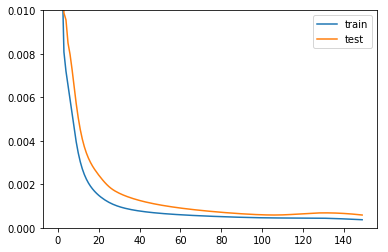

In [13]:
plt.plot(history['train'], '-', label='train')
plt.plot(history['test'], '-', label='test')
plt.ylim([0, 0.01])
plt.legend()

In [14]:
model.trainable_variables

[<tf.Variable 'attention_model/Q/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[10.98553, -6.47468]], dtype=float32)>,
 <tf.Variable 'attention_model/K/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[ 14.428955, -10.657505]], dtype=float32)>,
 <tf.Variable 'attention_model/V/kernel:0' shape=(1, 2) dtype=float32, numpy=array([[ 1.0407985 , -0.06015549]], dtype=float32)>]